In [152]:
import numpy as np
import pyedflib
import plotly.graph_objects as go
import pandas as pd
from gtda.time_series import SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve
from gtda.plotting import plot_point_cloud, plot_heatmap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from gtda.pipeline import Pipeline 


def read_edf_file(file_path):
    """
    Reads an .edf file and returns the EEG and EMG streams as pandas DataFrames.
    """
    f = pyedflib.EdfReader(file_path)

    # Assuming the EEG channel is the first channel and EMG is the second channel
    eeg_signal = f.readSignal(0)
    emg_signal = f.readSignal(1)

    # Extract the channel names for the DataFrame
    eeg_channel_name = f.getSignalLabels()[0]
    emg_channel_name = f.getSignalLabels()[1]

    # Get the sample frequency
    sample_frequency = f.getSampleFrequency(0)  # Assuming both streams have the same frequency

    # Calculate the timestamps for the samples
    n_samples = min(len(eeg_signal), len(emg_signal))
    time = [i / sample_frequency for i in range(n_samples)]

    # Create pandas DataFrame
    df = pd.DataFrame({
        'Time': time,
        eeg_channel_name: eeg_signal[:n_samples],
        emg_channel_name: emg_signal[:n_samples],
    })

    # Close the EdfReader
    f.close()

    return df

file = 'edf_293.edf'

data = read_edf_file(file)


x = data.Time
y = data.EEG

In [38]:
# Labels
label_df = pd.read_csv("Data_293.csv")
labels = label_df["NAPS_Numeric"].iloc[1:]
labels = [int(label) for label in labels]

# Local Approach

In [97]:
# How many segments do you want to analyze per label?
no_segments = 100

In [98]:
# Extract the indices of the first 10 of each of the single labels occuring in the list labels 

indices_dict = {}  # A dictionary to store indices for each label

for label in list(set(labels)):
    indices = [index for index, value in enumerate(labels) if value == label][:no_segments]
    indices_dict[label] = indices


In [99]:
def segment_data(df, segment_size, step_size = 2):
    """
    Segments the DataFrame into non-overlapping intervals.
    """
    n_segments = int(df["Time"].iloc[-1]) // segment_size
    eeg_segments = []
    emg_segments = []

    for i in range(n_segments):
        start_idx = int(i* segment_size*1000/step_size)
        end_idx = start_idx + int(segment_size*1000/step_size)
        segment = df.iloc[start_idx:end_idx]
        eeg_segments.append(list(segment["EEG"]))
        emg_segments.append(list(segment["EMG"]))

    return eeg_segments, emg_segments

In [100]:
# Segment the data
segment_length = 4  # seconds
eeg_segments, emg_segments = segment_data(data, segment_length, step_size = 2)

## Tuning the embedding dimension and time delay

There are two techniques that can be used to determine these parameters automatically:
- Mutual information to determine the time delay
- False nearest neighbours to determine the embedding dimension

In [101]:
# Initialise the embedding

max_embedding_dimension = 30
max_time_delay = 30
stride = 5

embedder = SingleTakensEmbedding(
    parameters_type="search",
    time_delay=max_time_delay,
    dimension=max_embedding_dimension,
    stride=stride,
)

In [102]:
def fit_embedder(embedder: SingleTakensEmbedding, y: np.ndarray, verbose: bool=True) -> np.ndarray:
    """Fits a Takens embedder and displays optimal search parameters."""
    y_embedded = embedder.fit_transform(y)

    if verbose:
        print(f"Shape of embedded time series: {y_embedded.shape}")
        print(
            f"Optimal embedding dimension is {embedder.dimension_} and time delay is {embedder.time_delay_}"
        )

    return y_embedded

In [103]:
# Look at some random segments
y_embedded = fit_embedder(embedder, eeg_segments[0])
y_embedded = fit_embedder(embedder, eeg_segments[100])
y_embedded = fit_embedder(embedder, eeg_segments[177])
y_embedded = fit_embedder(embedder, eeg_segments[1000])
# The optimal values are all similar (=> Just use embedding dimension 5 and time delay 25)

Shape of embedded time series: (380, 5)
Optimal embedding dimension is 5 and time delay is 26
Shape of embedded time series: (383, 4)
Optimal embedding dimension is 4 and time delay is 29
Shape of embedded time series: (383, 5)
Optimal embedding dimension is 5 and time delay is 22
Shape of embedded time series: (373, 6)
Optimal embedding dimension is 6 and time delay is 27


In [104]:
# Setting the parameters

embedding_dimension= 5
embedding_time_delay = 25
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

## Examining segments with label 1

In [105]:
# Initial definition of embedding dictionary for all labels
y_embedded = {}

# Loop through the first positions with label '1'
for label_idx in indices_dict[1]:
    y_embedded[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])

# Reshape (?)
for label_idx in indices_dict[1]:
    y_embedded[label_idx] = y_embedded[label_idx][None, :, :]


# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)

diagrams = {}

for label_idx in indices_dict[1]:
    diagrams[label_idx] = persistence.fit_transform(y_embedded[label_idx])

### Extracting features

In [106]:
PE = PersistenceEntropy()

persistence_entropy1 = {}

for label_idx in indices_dict[1]:
    persistence_entropy1[label_idx] = PE.fit_transform(diagrams[label_idx])

In [107]:
AM = Amplitude()

amplitude1 = {}

for label_idx in indices_dict[1]:
    amplitude1[label_idx] = AM.fit_transform(diagrams[label_idx])

In [108]:
NP = NumberOfPoints()

no_points1 = {}

for label_idx in indices_dict[1]:
    no_points1[label_idx] = NP.fit_transform(diagrams[label_idx])

In [109]:
CP = ComplexPolynomial()

complex_polynomial1 = {}

for label_idx in indices_dict[1]:
    complex_polynomial1[label_idx] = CP.fit_transform(diagrams[label_idx])

## Examining segments with label 3

In [110]:
# Loop through the first positions with label '3'

y_embedded = {} # TODO one dictionary

for label_idx in indices_dict[3]:
    y_embedded[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])

In [111]:
# Reshape (?)
for label_idx in indices_dict[3]:
    y_embedded[label_idx] = y_embedded[label_idx][None, :, :]

# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)


diagrams = {}

for label_idx in indices_dict[3]:
    diagrams[label_idx] = persistence.fit_transform(y_embedded[label_idx])

### Extracting features

In [112]:
PE = PersistenceEntropy()

persistence_entropy3 = {}

for label_idx in indices_dict[3]:
    persistence_entropy3[label_idx] = PE.fit_transform(diagrams[label_idx])


In [113]:
AM = Amplitude()

amplitude3 = {}

for label_idx in indices_dict[3]:
    amplitude3[label_idx] = AM.fit_transform(diagrams[label_idx])

In [114]:
NP = NumberOfPoints()

no_points3 = {}

for label_idx in indices_dict[3]:
    no_points3[label_idx] = NP.fit_transform(diagrams[label_idx])

In [115]:
CP = ComplexPolynomial()

complex_polynomial3 = {}

for label_idx in indices_dict[3]:
    complex_polynomial3[label_idx] = CP.fit_transform(diagrams[label_idx])

## Examining segments with label 4

In [116]:
# Loop through the first positions with label '4'

y_embedded = {} # TODO one dictionary

for label_idx in indices_dict[4]:
    y_embedded[label_idx] = embedder_periodic.fit_transform(eeg_segments[label_idx])

In [117]:
# Reshape (?)
for label_idx in indices_dict[4]:
    y_embedded[label_idx] = y_embedded[label_idx][None, :, :]

# 0 - connected components, 1 - loops, 2 - voids
homology_dimensions = [0, 1, 2]

persistence = VietorisRipsPersistence(
    homology_dimensions=homology_dimensions, n_jobs=10
)


diagrams = {}

for label_idx in indices_dict[4]:
    diagrams[label_idx] = persistence.fit_transform(y_embedded[label_idx])

### Extracting features

In [118]:
PE = PersistenceEntropy()

persistence_entropy4 = {}

for label_idx in indices_dict[4]:
    persistence_entropy4[label_idx] = PE.fit_transform(diagrams[label_idx])


In [119]:
AM = Amplitude()

amplitude4 = {}

for label_idx in indices_dict[4]:
    amplitude4[label_idx] = AM.fit_transform(diagrams[label_idx])

In [120]:
NP = NumberOfPoints()

no_points4 = {}

for label_idx in indices_dict[4]:
    no_points4[label_idx] = NP.fit_transform(diagrams[label_idx])

In [121]:
CP = ComplexPolynomial()

complex_polynomial4 = {}

for label_idx in indices_dict[4]:
    complex_polynomial4[label_idx] = CP.fit_transform(diagrams[label_idx])

## Plotting the distribution of features for different labels

In [122]:
def extract_coordinates(dictionary):
    coordinates = [tuple(arr[0]) for arr in dictionary.values()]
    return zip(*coordinates)

### Persistence Entropy

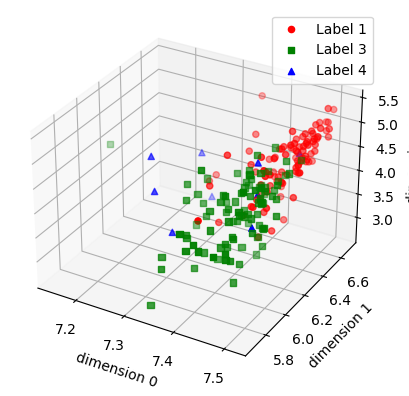

In [123]:
x1, y1, z1 = extract_coordinates(persistence_entropy1)
x3, y3, z3 = extract_coordinates(persistence_entropy3)
x4, y4, z4 = extract_coordinates(persistence_entropy4)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot keys from each dictionary with different colors
ax.scatter(x1, y1, z1, c='r', marker='o', label='Label 1')
ax.scatter(x3, y3, z3, c='g', marker='s', label='Label 3')
ax.scatter(x4, y4, z4, c='b', marker='^', label='Label 4')

ax.set_xlabel('dimension 0')
ax.set_ylabel('dimension 1')
ax.set_zlabel('dimension 2')

ax.legend()

plt.show()

### Amplitude

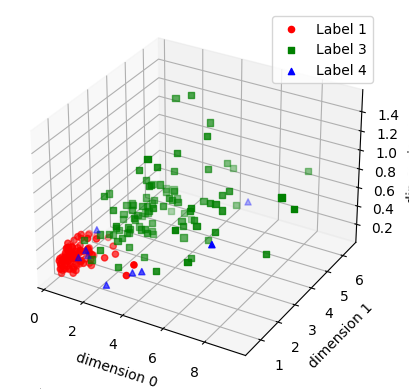

In [124]:
x1, y1, z1 = extract_coordinates(amplitude1)
x3, y3, z3 = extract_coordinates(amplitude3)
x4, y4, z4 = extract_coordinates(amplitude4)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot keys from each dictionary with different colors
ax.scatter(x1, y1, z1, c='r', marker='o', label='Label 1')
ax.scatter(x3, y3, z3, c='g', marker='s', label='Label 3')
ax.scatter(x4, y4, z4, c='b', marker='^', label='Label 4')

ax.set_xlabel('dimension 0')
ax.set_ylabel('dimension 1')
ax.set_zlabel('dimension 2')

ax.legend()

plt.show()

### Number of Points

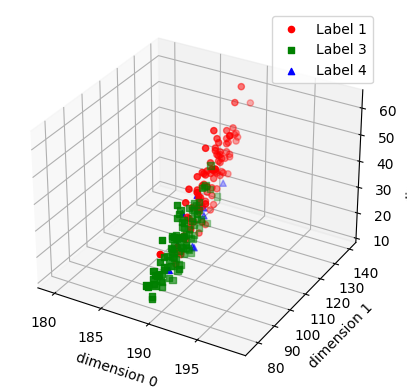

In [156]:
x1, y1, z1 = extract_coordinates(no_points1)
x3, y3, z3 = extract_coordinates(no_points3)
x4, y4, z4 = extract_coordinates(no_points4)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot keys from each dictionary with different colors
ax.scatter(x1, y1, z1, c='r', marker='o', label='Label 1')
ax.scatter(x3, y3, z3, c='g', marker='s', label='Label 3')
ax.scatter(x4, y4, z4, c='b', marker='^', label='Label 4')

ax.set_xlabel('dimension 0')
ax.set_ylabel('dimension 1')
ax.set_zlabel('dimension 2')

ax.legend()

plt.show()

### Complex Polynomials

## Scatter plots

This is an example for showing dependencies between the number of holes of different dimensions in a persistence diagram. It's mainly for fun.

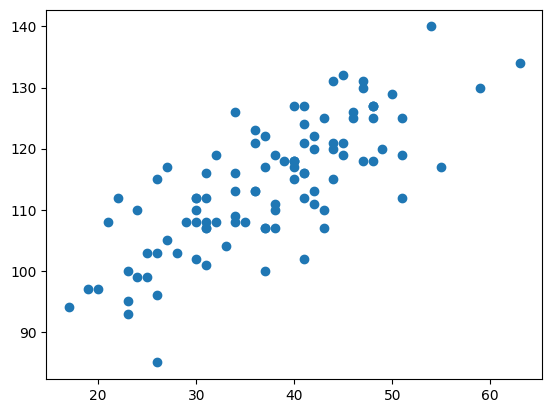

In [179]:
plt.scatter(z1, y1)
plt.show()

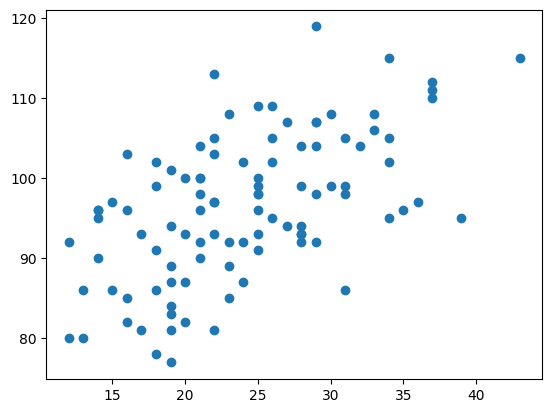

In [182]:
plt.scatter(z3, y3)
plt.show()

The numbers of tunnels and voids are positively correlated.

# Global Approach

In [126]:
# Merge Together all segments with the same label

grouped_segments = {label: [] for label in {1, 2, 3, 4, 5, 7}}

# Group segments based on labels
for segment, label in zip(eeg_segments, labels):
    grouped_segments[label].extend(segment)

# Create merged lists for each label
merged_lists = {label: merged_segment for label, merged_segment in grouped_segments.items()}

## PCA Point Clouds

In [150]:
y_embedded1 = embedder_periodic.fit_transform(merged_lists[1][:10000])

# Apply dimensionality PCA to project down to 3-dimensions for visualisation:
pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded1)
plot_point_cloud(y_embedded_pca)

In [151]:
y_embedded3 = embedder_periodic.fit_transform(merged_lists[3][:10000])

# Apply dimensionality PCA to project down to 3-dimensions for visualisation:
pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded3)
plot_point_cloud(y_embedded_pca)

In [129]:
y_embedded4 = embedder_periodic.fit_transform(merged_lists[4][:10000])

# Apply dimensionality PCA to project down to 3-dimensions for visualisation:
pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded4)
plot_point_cloud(y_embedded_pca)

## Persistence Diagrams

In [130]:
# Persistance Diagram for the whole data labelled with 1 (or rather first 10,000 entries)
y_embedded = y_embedded1[None, :, :]

global_diagram1 = persistence.fit_transform_plot(y_embedded)
global_persistence_entropy1 = PE.fit_transform(global_diagram1)
global_amplitude1  = AM.fit_transform(global_diagram1)
global_no_points1  = NP.fit_transform(global_diagram1)
global_complex_polynomial1  = CP.fit_transform(global_diagram1)

print("Features for dimensions 0, 1, 2:")
print("")
print("Persistence Entropies: " + str(global_persistence_entropy1))
print("Amplitudes: " + str(global_amplitude1))
print("Numbers of Points: " + str(global_no_points1))
#print("Complex Polynomials: " + str(global_complex_polynomial1))

Features for dimensions 0, 1, 2:

Persistence Entropies: [[9.87654874 9.32186133 8.44756408]]
Amplitudes: [[3.78326267e-07 1.02691430e-07 3.76006327e-08]]
Numbers of Points: [[989 892 497]]


In [131]:
# Persistance Diagram for the whole data labelled with 3 (or rather first 10,000 entries)
y_embedded = y_embedded3[None, :, :]

global_diagram3 = persistence.fit_transform_plot(y_embedded)

global_persistence_entropy3 = PE.fit_transform(global_diagram3)
global_amplitude3  = AM.fit_transform(global_diagram3)
global_no_points3  = NP.fit_transform(global_diagram3)
global_complex_polynomial3  = CP.fit_transform(global_diagram3)

print("Features for dimensions 0, 1, 2:")
print("")
print("Persistence Entropies: " + str(global_persistence_entropy3))
print("Amplitudes: " + str(global_amplitude3))
print("Numbers of Points: " + str(global_no_points3))
#print("Complex Polynomials: " + str(global_complex_polynomial3))

Features for dimensions 0, 1, 2:

Persistence Entropies: [[9.7930794  9.02094845 7.56132447]]
Amplitudes: [[1.97563492e-06 2.42605705e-07 7.94258051e-08]]
Numbers of Points: [[989 727 260]]


In [132]:
# Persistance Diagram for the whole data labelled with 4 (or rather first 10,000 entries)
y_embedded = y_embedded4[None, :, :]

global_diagram4 = persistence.fit_transform_plot(y_embedded)

global_persistence_entropy4 = PE.fit_transform(global_diagram4)
global_amplitude4  = AM.fit_transform(global_diagram4)
global_no_points4  = NP.fit_transform(global_diagram4)
global_complex_polynomial4  = CP.fit_transform(global_diagram4)

print("Features for dimensions 0, 1, 2:")
print("")
print("Persistence Entropies: " + str(global_persistence_entropy4))
print("Amplitudes: " + str(global_amplitude4))
print("Numbers of Points: " + str(global_no_points4))
#print("Complex Polynomials: " + str(global_complex_polynomial3))

Features for dimensions 0, 1, 2:

Persistence Entropies: [[9.69508959 9.14127461 8.07834249]]
Amplitudes: [[3.45475451e-06 1.94257191e-07 5.11881133e-08]]
Numbers of Points: [[989 796 383]]


#### Analysis 
- They visually look different, but also have different scales
- The amplitude of connectivities for label 1 is much lower than for the other two labels
-  Label 3 also has relatively few voids, label 1 has the most voids (which is also visible in the "Number of Points" plot in the Local Analyis

## Persistence Landscape

In [133]:
PL = PersistenceLandscape()


In [134]:
# Persistence landscape for label 1

persistence_landscape = PL.fit_transform(global_diagram1)

PL.plot(persistence_landscape)

In [135]:
# Persistence landscape for label 3

persistence_landscape = PL.fit_transform(global_diagram3)

PL.plot(persistence_landscape)

In [136]:
# Persistence landscape for label 4

persistence_landscape = PL.fit_transform(global_diagram4)

PL.plot(persistence_landscape)

## Silhouette

In [137]:
from gtda.diagrams import PersistenceEntropy, Amplitude, NumberOfPoints, ComplexPolynomial, PersistenceLandscape, HeatKernel, Silhouette, BettiCurve

SH = Silhouette()


In [138]:
silhouette1 = SH.fit_transform(global_diagram1)

SH.plot(silhouette1)

In [139]:
silhouette3 = SH.fit_transform(global_diagram3)

SH.plot(silhouette3)

In [140]:
silhouette4 = SH.fit_transform(global_diagram4)

SH.plot(silhouette4)

## Heat Kernel 

In [141]:
HK = HeatKernel(sigma=0.000003, n_bins=100, n_jobs=-1)

In [142]:
# Heat kernel for label 1
heatkernel = HK.fit_transform(global_diagram1)
HK.plot(heatkernel, homology_dimension_idx=1)

In [143]:
heatkernel = HK.fit_transform(global_diagram3)
HK.plot(heatkernel, homology_dimension_idx=1)

In [144]:
heatkernel = HK.fit_transform(global_diagram4)
HK.plot(heatkernel, homology_dimension_idx=1)

# Experiments

## Experiments with PCA

Comparing the two approaches for the noisy level 4

- Using an Embedding dimension of 5 and reducing the space to 3D with PCA
- Using an Embedding dimension of 3 directly

In [145]:
# Without PCA
embedding_dimension= 3
embedding_time_delay = 25
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded_without_pca = embedder_periodic.fit_transform(merged_lists[4][:10000])

plot_point_cloud(y_embedded_without_pca)

In [146]:
# PCA

embedding_dimension= 5 # dimension 7 instead of 5
embedding_time_delay = 25
stride = 10

embedder_periodic = SingleTakensEmbedding(
    parameters_type="fixed",
    n_jobs=2,
    time_delay=embedding_time_delay,
    dimension=embedding_dimension,
    stride=stride,
)

y_embedded = embedder_periodic.fit_transform(merged_lists[4][:10000])

pca = PCA(n_components=3)
y_embedded_pca = pca.fit_transform(y_embedded)
plot_point_cloud(y_embedded_pca)

In [147]:
def max_distance(points):
  n_points = points.shape[0]
  max_distance = 0
  for i in range(n_points):
    for j in range(i + 1, n_points):
      distance = np.linalg.norm(points[i] - points[j])
      if distance > max_distance:
        max_distance = distance

  return max_distance

print(max_distance(y_embedded_without_pca))
print(max_distance(y_embedded_pca))

0.0014250165613844746
0.001609800554044589


In the PCA approach, the point cloud looks "rounder", so there is not one primary component. They have a similar amount of outliers, but the outliers in the PCA approach are more equally distributed. The point cloud without PCA has a smaller "diameter". What happens if I plot the persistence diagram?

In [148]:
# Persistance Diagram for approach without PCA
y_embedded = y_embedded_without_pca[None, :, :]

diagram_without_pca = persistence.fit_transform_plot(y_embedded)

In [149]:
# Persistance Diagram for approach with PCA
y_embedded = y_embedded_pca[None, :, :]

diagram_with_pca = persistence.fit_transform_plot(y_embedded)


Overall, the PCA approach probably does not add much value here.

## Experimental Code

In [133]:
# If I add the labels to the DataFrame data as a column target, this is a fancy way of
# Retrieving different datasets for each label

data = {
    "x": [1, 2, 3, 4, 5, 6],
    "y": [10, 20, 30, 40, 50, 60],
    "z": [100, 200, 300, 400, 500, 600],
    "target": ["A", "B", "A", "C", "B", "C"]
}
df = pd.DataFrame(data)

# Calculate point_clouds
point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)

Furhter pre- and postprocessing:
- Remove outliers before? (Artifacts Removal)
- Remove noise from persistance diagrams (holes with very low persistence)
- Other preprocessing (PCA? Wavelet Decomposition? "Downsampling")?
- Later use filtering on persistence diagrams (gtda.diagrams.Filtering() )
- Scaling (Did not immediately work on Timeseries data)?